# Le Framework Rational Speech Act (RSA)

Le langage humain repose sur l’hypothèse de **coopération** : les locuteurs tentent de fournir des informations pertinentes à l’interlocuteur ; les interlocuteurs peuvent alors raisonner **pragmatiquement** sur l’état du monde le plus probable étant donné l’énoncé choisi par le locuteur.

Le **framework RSA** (Rational Speech Act) formalise ces idées à l’aide de modèles de décision et de raisonnement probabilistes. L’idée générale est :

- On définit un **"écouteur littéral"** (*literal_listener*) qui interprète un énoncé littéralement (l’énoncé doit être vrai dans l’état).
- On définit un **"locuteur coopératif"** (*speaker*) qui choisit un énoncé pour que l’écouteur littéral devine l’état.
- On définit enfin un **"récepteur pragmatique"** (*pragmatic_listener*) qui se dit : « Si le locuteur a choisi cet énoncé, c’est parce qu’il voulait que l’écouteur littéral l’interprète d’une certaine manière ; donc l’état le plus probable est… ».

Nous allons illustrer ce cadre RSA à travers deux exemples :
1. Un **RSA simple** (domaines *none / some / all*), mettant en évidence une **implicature scalaire**.
2. Un **RSA plus avancé** pour capturer l’**hyperbole** (ex. : « Ça coûte un million ! »). On modélise un **état** contenant un prix et un degré d’excitation/irritation (*arousal*), et on introduit la notion de **QUD** (Question Under Discussion) pour représenter ce que le locuteur souhaite vraiment communiquer.

Nous verrons également comment prolonger ce cadre pour expliquer :
- Les **imprécisions** numérales (ou *pragmatic halo*), ex. “Il a coûté 50 dollars” signifiant en réalité ~50.
- L’**ironie**, en ajoutant des dimensions affectives (valence + arousal).

*(Remarque : ce notebook suppose une version de Pyro postérieure à [4392d54], mais la plupart des fonctionnalités devraient marcher sur des versions récentes.)*


## Infrastructure pour l’inférence par recherche exhaustive

[Pyro](https://pyro.ai/) est une bibliothèque de **programmation probabiliste**, construite au-dessus de PyTorch.  
Elle permet de définir des modèles stochastiques et d'effectuer l’inférence via diverses méthodes (variationnelle, MCMC, etc.).

Ici, nous utilisons une approche simplifiée basée sur la **recherche exhaustive** via `Search`, bien adaptée aux **espaces d’états restreints**.  
Concrètement, `Search` explore toutes les trajectoires possibles, puis `HashingMarginal` regroupe les résultats pour obtenir la **distribution marginale**.

### Outils utilisés :
- `Search(fn).run(*args)`: exécute `fn` en explorant **toutes** les options possibles (jusqu’à une limite).
- `HashingMarginal(...)`: agrège les trajectoires identiques et calcule les probabilités marginales.
- `memoize` (`functools.lru_cache`) : met en cache les résultats pour éviter les recomputations inutiles.

Ainsi, si `literal_listener("some")` est appelé plusieurs fois, le résultat est directement récupéré du cache.

### Limite de l’approche exhaustive
Cette approche est idéale pour **des micro-domaines** où le nombre d’états est gérable, mais elle devient vite coûteuse si l’espace d’états grandit trop (ex. avec 100 valeurs de prix).  
Dans ces cas, on privilégiera des méthodes d’inférence plus scalables comme MCMC ou SVI.


In [1]:
%pip install pyro-ppl

import collections
import functools
import queue
import torch

import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.abstract_infer import TracePosterior

def memoize(fn=None, **kwargs):
    if fn is None:
        return lambda _fn: memoize(_fn, **kwargs)
    return functools.lru_cache(**kwargs)(fn)

class HashingMarginal(dist.Distribution):
    """
    Convertit un `TracePosterior` (ensemble de traces d’exécution Pyro) en distribution marginale
    sur la valeur de retour (ou sur certains sites Pyro spécifiques).
    """
    def __init__(self, trace_dist, sites=None):
        super().__init__()
        self.trace_dist = trace_dist
        if sites is None:
            sites = "_RETURN"
        self.sites = sites
        self.has_enumerate_support = True

    @memoize(maxsize=10)
    def _dist_and_values(self):
        vals_map = collections.OrderedDict()
        logits_map = collections.OrderedDict()
        for tr, logwt in zip(self.trace_dist.exec_traces, self.trace_dist.log_weights):
            if isinstance(self.sites, str):
                val = tr.nodes[self.sites]["value"]
            else:
                val = {s: tr.nodes[s]["value"] for s in self.sites}
            if not torch.is_tensor(logwt):
                logwt = torch.tensor(logwt)

            # Clef de hachage pour le dictionnaire
            h = self._hash_value(val)
            if h in logits_map:
                from pyro.distributions.util import logsumexp
                old = logits_map[h]
                new = logsumexp(torch.stack([old, logwt]), dim=-1)
                logits_map[h] = new
            else:
                logits_map[h] = logwt
                vals_map[h] = val

        # Normalisation
        from pyro.distributions.util import logsumexp
        all_logits = torch.stack(list(logits_map.values()))
        norm = logsumexp(all_logits, dim=-1)
        final_logits = all_logits - norm
        cat_dist = dist.Categorical(logits=final_logits)
        return cat_dist, vals_map

    def _hash_value(self, v):
        if torch.is_tensor(v):
            return hash(v.cpu().numpy().tobytes())
        elif isinstance(v, dict):
            return hash(tuple(sorted(v.items())))
        else:
            return hash(v)

    def sample(self):
        catd, vals_map = self._dist_and_values()
        idx = catd.sample()
        return list(vals_map.values())[idx]

    def log_prob(self, val):
        catd, vals_map = self._dist_and_values()
        h = self._hash_value(val)
        keys = list(vals_map.keys())
        if h not in keys:
            return torch.tensor(float("-inf"))
        idx = keys.index(h)
        return catd.log_prob(torch.tensor([idx]))

    def enumerate_support(self):
        catd, vals_map = self._dist_and_values()
        return list(vals_map.values())

class Search(TracePosterior):
    """Effectue une recherche exhaustive (ou quasi) sur le modèle Pyro."""
    def __init__(self, model, max_tries=int(1e6), **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.max_tries = max_tries

    def _traces(self, *args, **kwargs):
        q = queue.Queue()
        q.put(poutine.Trace())
        queue_model = poutine.queue(self.model, queue=q, max_tries=self.max_tries)
        p = poutine.trace(queue_model)
        while not q.empty():
            tr = p.get_trace(*args, **kwargs)
            yield tr, tr.log_prob_sum()


Note: you may need to restart the kernel to use updated packages.


## Décorateur `Marginal` pour créer facilement des distributions

Nous définissons ci-dessous un décorateur `Marginal` qui, appliqué à une fonction stochastique Pyro (par exemple, un *listener*), renvoie **directement** la distribution marginale sur sa valeur de retour (ou sur un site `obs`).

In [2]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import functools

def Marginal(fn):
    """
    Décorateur : transforme une fonction stochastique (Pyro)
    en distribution marginale (via Search + HashingMarginal).
    """
    @functools.lru_cache(None)
    def run_and_marginal(*args):
        posterior = Search(fn).run(*args)
        return HashingMarginal(posterior)
    return run_and_marginal

print("Pyro version =", pyro.__version__)

Pyro version = 1.9.1


# Partie A : Un RSA simple (none / some / all)

Nous illustrons d’abord un micro-domaine :
- Il y a 4 objets (par exemple 4 boules) et un certain nombre peut être bleu : 0, 1, 2, 3, ou 4.
- Le locuteur peut dire « none are blue », « some are blue », ou « all are blue ».

### Priors et fonction de sens (meaning)
1. `state_prior()` : distribution **uniforme** sur le nombre d’objets bleus (0,1,2,3,4).
2. `utterance_prior()` : distribution **uniforme** sur les trois énoncés.
3. `meaning(utt, n)` : renvoie True si l’énoncé `utt` est littéralement vrai pour un état où il y a `n` objets bleus.


In [3]:
total_number = 4

def state_prior():
    # Nombre d’objets bleus, uniform 0..4
    n = pyro.sample("state", dist.Categorical(probs=torch.ones(total_number+1)/(total_number+1)))
    return n

def utterance_prior():
    # 3 énoncés : none / some / all
    ix = pyro.sample("utt", dist.Categorical(probs=torch.ones(3)/3))
    return ["none", "some", "all"][ix]

meanings = {
    "none": lambda n: (n == 0),
    "some": lambda n: (n > 0),
    "all":  lambda n: (n == total_number)
}

def meaning(utt, n):
    return meanings[utt](n)

### Les définitions RSA

1. **`literal_listener(u)`** impose que l’énoncé `u` soit littéralement vrai. Concrètement :
   ```python
   pyro.factor("literal", 0.) if meaning(...) else pyro.factor("literal", -9999999.)
   ```

2. **`speaker(s)`** : choisit un énoncé pour que le `literal_listener` retrouve l’état `s`. On peut pondérer la qualité de ce choix par un paramètre alpha (1.0 pour un log-softmax).

3. **`pragmatic_listener(u)`** : infère l’état plausible si le locuteur a effectivement choisi l’énoncé `u`. Cela se fait en observant l’échantillonage `pyro.sample("speaker", speaker(s), obs=u)`.



In [4]:
WRONG_COST = -10.0  # pénalité quand l'énoncé est faux

@Marginal
def literal_listener(utt):
    s = state_prior()
    pyro.factor("literal_meaning", 0. if meaning(utt, s) else WRONG_COST)
    return s

@Marginal
def speaker(s):
    alpha = 1.0
    with poutine.scale(scale=torch.tensor(alpha)):
        u = utterance_prior()
        # On impose que le literal_listener(u) = s
        pyro.sample("listener", literal_listener(u), obs=s)
    return u

@Marginal
def pragmatic_listener(u):
    s = state_prior()
    pyro.sample("speaker", speaker(s), obs=u)
    return s


### Le locuteur et son degré de rationalité

Dans la définition du `speaker`, on a :
    
    with poutine.scale(scale=torch.tensor(alpha)):

Ce `poutine.scale` multiplie la **log-probabilité** de tout ce qui se passe dans ce bloc par le facteur `alpha`.  
En pratique, cela joue le rôle d’un **tempérage** (temperature) :

- Si `alpha = 1.0`, on obtient un choix "log-softmax" standard.
- Si `alpha > 1.0` (ex. 5.0), le locuteur devient plus **strictement rationnel** (le meilleur énoncé est surpondéré de manière exponentielle).
- Si `alpha < 1.0` (ex. 0.5), le locuteur est plus "bruyant" ou moins optimal ; il choisit parfois des énoncés suboptimaux.

Vous pouvez expérimenter différentes valeurs de `alpha` pour voir l’effet sur la distribution des énoncés produits par le `speaker`, ainsi que sur la distribution inférée par le `pragmatic_listener`.

### Visualisation d’une distribution discrète

Pour observer les distributions résultantes, on utilise un petit helper de plotting.

In [5]:
import matplotlib.pyplot as plt

def plot_dist(d, title=None):
    support = d.enumerate_support()
    probs = [d.log_prob(s).exp().item() for s in support]
    names = [str(s) for s in support]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    width = 0.3
    xvals = [i+1 for i in range(len(names))]
    ax.bar([x - width/2 for x in xvals], probs, width)
    ax.set_xticks(xvals)
    ax.set_xticklabels(names, rotation=45, ha='right')
    if title:
        ax.set_title(title)
    plt.show()

### Exemple : comment le *pragmatic_listener* interprète « some »

On observe la distribution renvoyée par `pragmatic_listener("some")`.

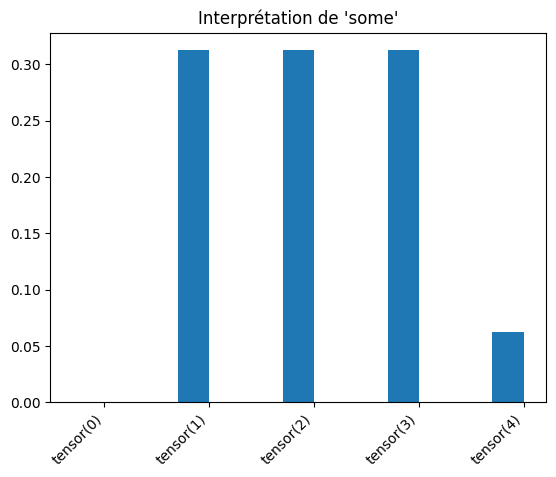

In [6]:
dist_some = pragmatic_listener("some")
plot_dist(dist_some, title="Interprétation de 'some'")

On voit que l’état « 4 bleus » devient peu probable, illustrant l’**implicature scalaire** :

- Littéralement, "some" = "au moins 1". Mais pragmatiquement, le locuteur aurait probablement choisi "all" s’il y avait 4 bleus.
- Donc "some" suggère qu’il n’y a pas 4.

Vous pouvez essayer d’autres énoncés, par exemple : `plot_dist(pragmatic_listener("none"))` ou `plot_dist(pragmatic_listener("all"))`.


### Interpréter les histogrammes

La fonction `plot_dist(d)` affiche un histogramme :  
- L’axe X liste les valeurs (par exemple, les états 0, 1, 2, etc.).  
- La hauteur des barres indique la probabilité associée à chaque valeur.

Exemple : pour `pragmatic_listener("some")`, vous verrez des barres en face de 0, 1, 2, 3, 4. On attend à peu près zéro probabilité pour 0 (car “some” impose > 0), et une probabilité faible pour 4 (car sinon le locuteur aurait dit “all”).

### Quelques exercices

1. **Changer le prior** : dans le RSA simple ("none/some/all"), faites en sorte que la probabilité de 2 et 3 soit plus élevée que 0 et 4. Regardez comment cela modifie l’interprétation de “some”.
2. **Jouer avec alpha** : mettez `alpha = 5.0` ou `alpha = 0.1` et observez les changements dans les choix d’énoncés du `speaker`.
3. **Modifier le coût** dans l’exemple d’hyperbole : si vous mettez un coût très élevé pour dire un nombre exact, le locuteur préférera presque toujours les nombres arrondis (souvent interprétés comme de l’exagération ou de l’imprécision).
4. **Nouvelle QUD** : ajoutez un QUD "isExpensive" (booléen) pour signifier “est-ce que ça coûte plus de 100 ?”. Voyez si la phrase “10000” devient un moyen efficace de signaler que c’est cher.


# Partie B : Modéliser l’hyperbole dans le RSA

## 1) Description générale

Exemple :
« Ma bouilloire m’a coûté **un million** de dollars ! »

C’est bien sûr **faux** littéralement, mais commun en langage humain. Dans un RSA naïf, un locuteur **cohérent** ne peut pas prononcer un énoncé faux. Pour réconcilier cela avec l’observation de l’hyperbole, on introduit deux idées (Kao et al., 2014) :

1. L’état mental que le locuteur veut transmettre inclut un **aspect affectif** (par ex. l’irritation devant un prix élevé).
2. Le locuteur n’a pas nécessairement l’objectif de communiquer le prix exact, mais plutôt **la partie de l’état pertinente** au contexte (la QUD). Par exemple, si la QUD est « Suis-je irrité ? », dire « Ça m’a coûté un million ! » est un bon moyen de signaler que *c’est vraiment cher*.

Le récepteur pragmatique, ne sachant pas quelle était la QUD, va raisonnablement conclure qu’il y a *de fortes chances* que le vrai prix soit moins que “un million”, mais que le locuteur est très irrité.

On va illustrer cela avec un petit domaine discret pour le **prix** et un booléen pour l’**arousal**.


## 2) Domaine : `(price, arousal)`

On définit :
- Un prior sur `price` (en prenant quelques valeurs discrètes : 50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001).
- Pour chaque prix, une probabilité (modélisant la chance d’être irrité si c’est cher).
- L’état est alors un couple `(price, arousal)`.


In [7]:
State = collections.namedtuple("State", ["price", "arousal"])

def price_prior():
    values = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    probs = torch.tensor([
        0.4205, 0.3865,
        0.0533, 0.0538,
        0.0223, 0.0211,
        0.0112, 0.0111,
        0.0083, 0.0120
    ])
    ix = pyro.sample("price", dist.Categorical(probs=probs))
    return values[ix]

def arousal_prior(price):
    # plus le prix est élevé, plus on a de chance d’être irrité
    # (valeurs de Kao et al.)
    d = {
        50: 0.3173,
        51: 0.3173,
        500: 0.7920,
        501: 0.7920,
        1000: 0.8933,
        1001: 0.8933,
        5000: 0.9524,
        5001: 0.9524,
        10000: 0.9864,
        10001: 0.9864
    }
    val = pyro.sample("arousal", dist.Bernoulli(d[price])).item()
    return (val == 1)

def state_prior_h():
    p = price_prior()
    a = arousal_prior(p)
    return State(price=p, arousal=a)


## 3) Les QUD : "price", "arousal" ou les deux

La QUD (*Question Under Discussion*) représente l’information que le locuteur souhaite vraiment transmettre. Exemples :
- **price** : « je veux juste faire comprendre la valeur du prix »
- **arousal** : « je veux juste faire comprendre que je suis très irrité »
- **priceArousal** : « je veux communiquer à la fois le prix et le fait que je suis irrité »

Nous définissons un prior uniforme sur ces 3 QUD, et trois fonctions qui projettent un état `(price, arousal)` sur la dimension choisie.

In [8]:
def qud_is_expensive(st):
    # Renvoie True si le prix est > 100
    return st.price > 100

qud_fns = {
    "price":         lambda st: State(price=st.price, arousal=None),
    "arousal":       lambda st: State(price=None, arousal=st.arousal),
    "priceArousal":  lambda st: State(price=st.price, arousal=st.arousal),
    "isExpensive":   qud_is_expensive   # Nouvelle QUD
}

def qud_prior():
    keys = list(qud_fns.keys())
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(keys)) / len(keys)))
    return keys[ix]


## 4) Les énoncés possibles = un nombre (p. ex. 50, 51, 500, ...)

On prend un prior **uniforme** sur ces 10 valeurs d’énoncés. Littéralement, dire « 500 » signifie "le prix est 500".

In [9]:
def utterance_prior_h():
    utts = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    ix = pyro.sample("utt_h", dist.Categorical(probs=torch.ones(len(utts))/len(utts)))
    return utts[ix]

def meaning_h(utt, price):
    # littéralement, dire utt = price
    return (utt == price)


## 5) Définitions RSA + projection

Pour modéliser la transmission de l’information *pertinente* à la QUD, on procède ainsi :
1. On définit `literal_listener_h(utt)`, qui impose que `price == utt`.
2. On définit une fonction *project(d, qud)* qui projette une distribution d’états `d` sur la QUD choisie.
3. Le *speaker_h(st, qud)* pioche un énoncé `utt` (selon `utterance_prior_h`) et s’assure que, **une fois compris littéralement**, cela permette de transmettre la bonne valeur sur la QUD.
4. Le *pragmatic_listener_h(utt)* ne sait pas la QUD, donc il échantillonne `qud` selon `qud_prior()`, puis regarde comment le locuteur aurait pu produire `utt`.


In [10]:
@Marginal
def project(d, qud):
    """Projection d’une distribution d’états sur la QUD"""
    v = pyro.sample("proj", d)
    return qud_fns[qud](v)

@Marginal
def literal_listener_h(utt):
    st = state_prior_h()
    pyro.factor("literal_h", 0. if meaning_h(utt, st.price) else -9999999.)
    return st

@Marginal
def speaker_h(st, qud):
    alpha = 1.
    qudValue = qud_fns[qud](st)
    with poutine.scale(scale=torch.tensor(alpha)):
        utt = utterance_prior_h()
        lit_marg = literal_listener_h(utt)
        # On projette sur la QUD pour voir si ça correspond
        proj_dist = project(lit_marg, qud)
        pyro.sample("listener", proj_dist, obs=qudValue)
    return utt

@Marginal
def pragmatic_listener_h(utt):
    st = state_prior_h()
    q = qud_prior()
    sp = speaker_h(st, q)
    pyro.sample("speaker_obs", sp, obs=utt)
    return st


## 6) Exemple : l’énoncé « 10000 » (hyperbole)

Imaginons que nous observions le locuteur disant « Ça coûte 10.000 ». La probabilité a priori que le prix soit vraiment 10000 n’est pas négligeable, mais c’est plutôt rare.

En revanche, s’il voulait juste exprimer **son irritation** (QUD="arousal"), alors dire "10.000" est un moyen d’être informatif sur le fait que le locuteur est outré. Le *pragmatic_listener* va donc juger plus probable que le prix soit inférieur à 10.000, mais que l’arousal est haut.


In [11]:
d_10000 = pragmatic_listener_h(10000)
sup_10000 = d_10000.enumerate_support()
probs_10000 = [d_10000.log_prob(s).exp().item() for s in sup_10000]
for s, p in zip(sup_10000, probs_10000):
    print(f"Etat={s}  -> prob={p:.4f}")

Etat=State(price=50, arousal=False)  -> prob=0.0190
Etat=State(price=50, arousal=True)  -> prob=0.1719
Etat=State(price=51, arousal=False)  -> prob=0.0175
Etat=State(price=51, arousal=True)  -> prob=0.1580
Etat=State(price=500, arousal=False)  -> prob=0.0150
Etat=State(price=500, arousal=True)  -> prob=0.1087
Etat=State(price=501, arousal=False)  -> prob=0.0151
Etat=State(price=501, arousal=True)  -> prob=0.1097
Etat=State(price=1000, arousal=False)  -> prob=0.0032
Etat=State(price=1000, arousal=True)  -> prob=0.0513
Etat=State(price=1001, arousal=False)  -> prob=0.0030
Etat=State(price=1001, arousal=True)  -> prob=0.0485
Etat=State(price=5000, arousal=False)  -> prob=0.0007
Etat=State(price=5000, arousal=True)  -> prob=0.0275
Etat=State(price=5001, arousal=False)  -> prob=0.0007
Etat=State(price=5001, arousal=True)  -> prob=0.0272
Etat=State(price=10000, arousal=False)  -> prob=0.0025
Etat=State(price=10000, arousal=True)  -> prob=0.1897
Etat=State(price=10001, arousal=False)  -> prob

On devrait voir que **plusieurs** états (notamment ceux avec un prix plus bas mais arousal=TRUE) récoltent une probabilité appréciable, illustrant l’usage hyperbolique.


## 7) Pragmatic Halo : l’imprécision numérale

« J’ai payé 50 dollars » peut vouloir dire que le prix exact est 50 ou **à peu près** 50. Mais dire « 51 » implique une précision plus stricte. C’est ce que certains appellent le **pragmatic halo** ou slack.

Pour modéliser cela, on peut :
1. Ajouter une QUD "approxPrice" qui arrondit le prix.
2. Définir un **coût** plus bas pour un nombre "rond" (ex. 50, 500, 1000, 5000, 10000), et un coût plus élevé pour un nombre précis (51, 501, …).

Ensuite, le locuteur a tendance (via le paramètre alpha) à choisir l’énoncé de plus haut *utility* = *log(prob d’être correct) - coût*.

### Extension du code
On modifie :
- Les QUD pour ajouter `"approxPrice"`.
- Une fonction `utterance_cost(u)` plus élevée si *u* est un nombre précis plutôt qu’arrondi.
- Le prior sur les énoncés `utterance_prior()` devient un *Categorical(logits=...)* dépendant du coût.

Puis on peut définir le *speaker* et le *pragmatic_listener* de la même façon.
On verra alors :
- Dire "50" peut être interprété (par le pragmatic_listener) comme **à peu près 50**.
- Dire "51" sera interprété plus strictement.


In [12]:
# On définit pour arrondir un nombre au multiple de 10
def approx(x, b=10.):
    div = float(x)/b
    # arrondi simple
    rounded = int(div) + 1 if (div - int(div)) >= 0.5 else int(div)
    return int(b) * rounded

# On enrichit qud_fns avec 2 nouvelles QUD "approxPrice" et "approxPriceArousal"
qud_fns_extended = {
    "price":              lambda st: State(price=st.price, arousal=None),
    "arousal":            lambda st: State(price=None, arousal=st.arousal),
    "priceArousal":       lambda st: State(price=st.price, arousal=st.arousal),
    "approxPrice":        lambda st: State(price=approx(st.price), arousal=None),
    "approxPriceArousal": lambda st: State(price=approx(st.price), arousal=st.arousal)
}

def qud_prior_extended():
    keys = list(qud_fns_extended.keys())
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(keys))/len(keys)))
    return keys[ix]

def utterance_cost(u):
    # coût = 0 si c’est un multiple de 10, sinon plus élevé
    # (valeurs arbitraires)
    return 0.0 if (approx(u)==u) else 10.0

def utterance_prior_with_cost():
    utts = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    costs = [utterance_cost(u) for u in utts]
    # On convertit en logits = -coût
    logits = [-c for c in costs]
    ix = pyro.sample("utt_h2", dist.Categorical(logits=torch.tensor(logits)))
    return utts[ix]

@Marginal
def literal_listener_h2(utt):
    st = state_prior_h()
    # impose price=utt
    pyro.factor("literal_h2", 0. if (utt == st.price) else -9999999.)
    return st

@Marginal
def project2(d, qud):
    v = pyro.sample("proj2", d)
    return qud_fns_extended[qud](v)

@Marginal
def speaker_h2(st, qud):
    alpha = 1.
    qudValue = qud_fns_extended[qud](st)
    with poutine.scale(scale=torch.tensor(alpha)):
        utt = utterance_prior_with_cost()
        lit_marg = literal_listener_h2(utt)
        # proj
        proj_dist = project2(lit_marg, qud)
        pyro.sample("listener2", proj_dist, obs=qudValue)
    return utt

@Marginal
def pragmatic_listener_h2(utt):
    st = state_prior_h()
    q = qud_prior_extended()
    sp = speaker_h2(st, q)
    pyro.sample("speaker_obs2", sp, obs=utt)
    return st

# Optionnel : si on veut juste la distribution sur le price (marginalisant le arousal)
@Marginal
def pragmatic_listener_price_marginal(utt):
    return pyro.sample("pl_price", pragmatic_listener_h2(utt)).price

### Illustration : "50" vs "51"

On compare la distribution *pragmatique* sur le **prix** lorsque le locuteur dit "50" ou "51". On s’attend à voir un effet d’**halo pragmatique** :
- "50" peut facilement correspondre à un prix de 50 ou 51 (ou 52, etc.) si la QUD est "approxPrice".
- "51" est plus coûteux à dire et donc sera choisi plus volontiers si le prix est **vraiment** 51.


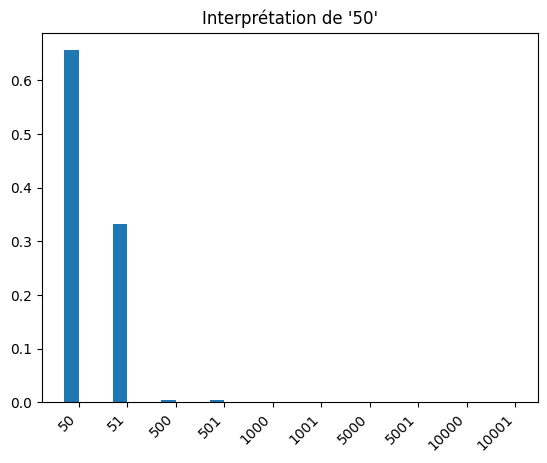

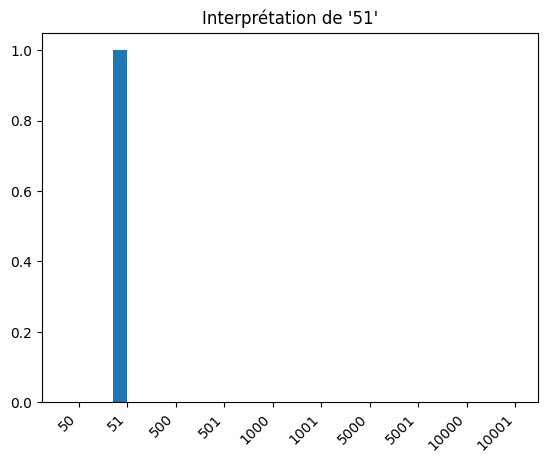

In [13]:
plot_dist(pragmatic_listener_price_marginal(50), title="Interprétation de '50'")
plot_dist(pragmatic_listener_price_marginal(51), title="Interprétation de '51'")

On observe que l’énoncé "50" va regrouper de la masse de probabilité sur "env. 50", tandis que "51" exclut la plupart des autres valeurs.


### Exercice : Étendre le halo pragmatique

On a défini une fonction d’approximation :

    def approx(x, b=10.):
        # arrondir x au multiple de b

Idée : créer une deuxième version qui arrondit au multiple de 100, par exemple :

    def approx100(x):
        return <...>

Puis ajoutez une nouvelle QUD, par exemple "approxPrice100", qui projette le price en arrondissant au multiple de 100.  
Incorporez cette nouvelle QUD dans `qud_fns_extended` et `qud_prior_extended`.  

Comparez alors :
- L’interprétation de "1000" sous la QUD "approxPrice" (arrondi au multiple de 10)  
- L’interprétation de "1000" sous la QUD "approxPrice100" (arrondi au multiple de 100)

Vous devriez voir encore plus de souplesse pour la QUD arrondie au multiple de 100, créant un "halo" plus grand autour de 1000.


# Remarque : Ironie et affect plus complexe

Dans l’exemple hyperbole, on a supposé un **affect** unidimensionnel : arousal = True/False. En réalité, on peut modéliser un espace en deux dimensions : (valence, arousal). L’étude de Kao et Goodman (2015) montre que cela permet de capturer de nouveaux phénomènes comme l’**ironie** : dire un énoncé joyeux quand on est en réalité en colère, etc.

Le cadre RSA est donc **extrêmement flexible** pour modéliser toutes sortes d’usages non littéraux (hyperbole, ironie, imprécision, litotes, métaphores, etc.), du moment qu’on formalise :
- l’**état** (incluant possiblement l’affect),
- la **QUD** (ou l’aspect pertinent de l’état),
- un **coût** (ou prior) sur les énoncés,
- un **paramètre** alpha pour la “rationalité” du choix du locuteur.


# Conclusion générale

Le RSA (Rational Speech Act) modélise la coopération dans le langage :
- Le **locuteur** choisit un énoncé pour être informatif (selon la QUD et son coût).
- L’**écouteur** infère l’état qui rendrait cet énoncé le plus probable, 
  en supposant un locuteur rationnel.

Cela permet d’expliquer :
- Les **implicatures** (ex. « some » => « pas all »),
- Les **hyperboles** (« un million ! » => forte irritation, même si littéralement faux),
- Les **imprécisions** numérales (« 50 » => ~50, quand préciser 51 a un coût plus grand),
- Voire l’**ironie** (si on modélise l’affect, ex. valence + arousal).

## Perspectives

- Pour un **grand** domaine, l’approche exhaustive (`Search`) est rapidement inapplicable ; on passerait à des méthodes MCMC ou d’inférence variationnelle.
- Le RSA peut aussi s’étendre à des **dialogues** multi-tours, ou intégrer des aspects plus complexes (métaphores, contextes multimodaux, etc.).

**Références :**
- [Kao et al., 2014] « Nonliteral number words » (*Cognitive Psychology*).
- [Kao & Goodman, 2015] « Formalizing the pragmatics of metaphor understanding ».
- [Frank & Goodman, 2012] « Predicting pragmatic reasoning in language games ».
- [Stanford Computation & Cognition Lab](https://langcog.stanford.edu/) pour en savoir plus.
